In [100]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [101]:
data = pd.read_csv('../data/raw/historical_data.csv')
data.columns

Index(['type', 'suburb', 'Count', 'Date', 'Median'], dtype='object')

In [102]:
data.columns = ['property_type', 'suburb', "count", 'quarter', 'rental_price']

In [103]:
data = data[(data['property_type'] == 'All properties') & (data['count'] > 10)]

In [104]:
data['quarter'] = pd.to_datetime(data['quarter'])

/var/folders/_7/sr3p02zn35v2xg1fm8dsbz6c0000gn/T/ipykernel_3688/2004859078.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['quarter'] = pd.to_datetime(data['quarter'])


In [105]:
data = data.sort_values(by=['suburb', 'quarter'])

In [106]:
data['rental_price_lag1'] = data.groupby(['suburb'])['rental_price'].shift(1)
data['rental_price_lag2'] = data.groupby(['suburb'])['rental_price'].shift(2)

In [107]:
data

,property_type,suburb,count,quarter,rental_price,rental_price_lag1,rental_price_lag2
80592,All properties,Albert Park-Middle Park-West St Kilda,1143.0,2000-03-01,260.0,NaN,NaN
80738,All properties,Albert Park-Middle Park-West St Kilda,1134.0,2000-06-01,260.0,260.0,NaN
80884,All properties,Albert Park-Middle Park-West St Kilda,1177.0,2000-09-01,270.0,260.0,260.0
81030,All properties,Albert Park-Middle Park-West St Kilda,1178.0,2000-12-01,275.0,270.0,260.0
81176,All properties,Albert Park-Middle Park-West St Kilda,1208.0,2001-03-01,275.0,275.0,270.0
...,...,...,...,...,...,...,...
93357,All properties,Yarraville-Seddon,1327.0,2022-03-01,470.0,475.0,480.0
93503,All properties,Yarraville-Seddon,1375.0,2022-06-01,470.0,470.0,475.0
93649,All properties,Yarraville-Seddon,1437.0,2022-09-01,475.0,470.0,470.0
93795,All properties,Yarraville-Seddon,1419.0,2022-12-01,485.0,475.0,470.0


In [108]:
data = data.dropna()

In [109]:
split_date = '2020-01-01'
train = data[data['quarter'] < split_date]
test = data[data['quarter'] >= split_date]

In [110]:
# Define features and target variable
X_train = train[['rental_price_lag1', 'rental_price_lag2']]
y_train = train['rental_price']

X_test = test[['rental_price_lag1', 'rental_price_lag2']]
y_test = test['rental_price']

In [111]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [112]:
cdf = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficients'])
print(cdf)

                   Coefficients
rental_price_lag1      0.999597
rental_price_lag2      0.002134


In [113]:
# Step 5: Evaluate on Test Data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test R²: {r2:.2f}")

Test MSE: 0.02
Test R²: 0.98


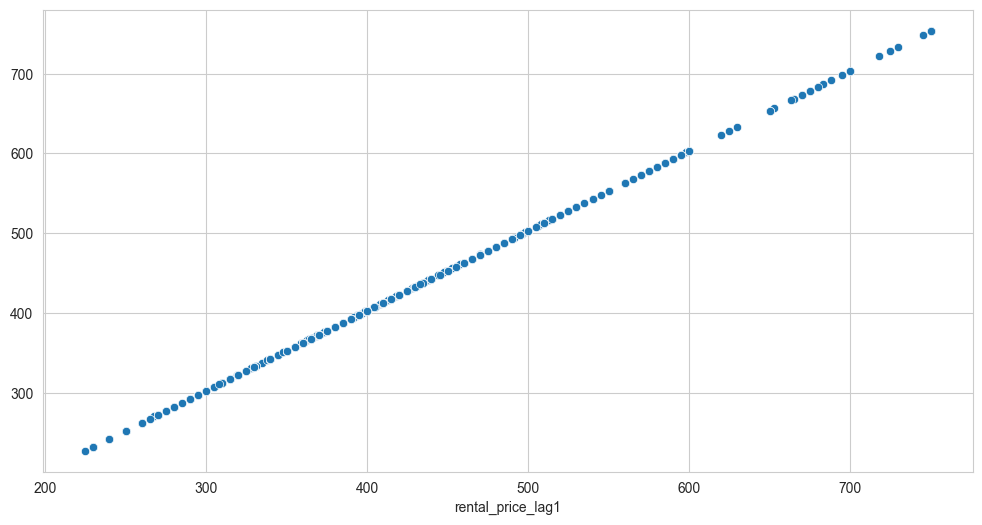

In [114]:
# Plot test predictions vs rental_price_lag1
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_test["rental_price_lag1"], y=y_pred)
plt.show()

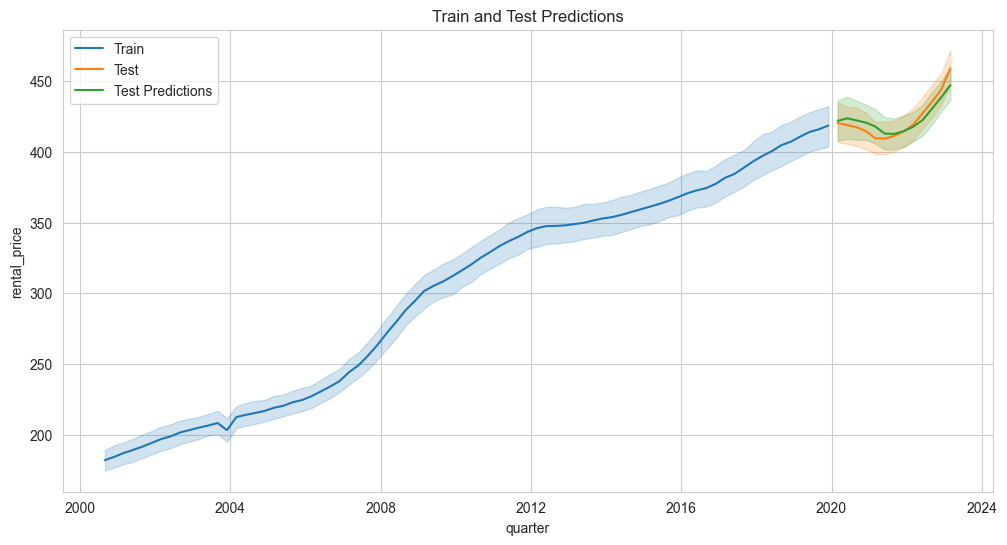

In [115]:
# Plot train and test predictions using sns lineplot
plt.figure(figsize=(12, 6))
sns.lineplot(x='quarter', y='rental_price', data=train, label='Train')
sns.lineplot(x='quarter', y='rental_price', data=test, label='Test')
sns.lineplot(x=test['quarter'], y=y_pred, label='Test Predictions')
plt.title('Train and Test Predictions')
plt.show()

In [116]:
future_quarters = pd.date_range(start='2023-03-01', periods=4 * 3, freq='QE')

In [117]:
last_known_data = data.groupby('suburb').last().reset_index()
last_known_data

,suburb,property_type,count,quarter,rental_price,rental_price_lag1,rental_price_lag2
0,Albert Park-Middle Park-West St Kilda,All properties,786.0,2023-03-01,545.0,525.0,500.0
1,Altona,All properties,4854.0,2023-03-01,430.0,420.0,415.0
2,Armadale,All properties,751.0,2023-03-01,490.0,460.0,450.0
3,Aspendale-Chelsea-Carrum,All properties,1215.0,2023-03-01,495.0,480.0,480.0
4,Bairnsdale,All properties,334.0,2023-03-01,400.0,400.0,380.0
...,...,...,...,...,...,...,...
141,Whittlesea,All properties,1605.0,2023-03-01,440.0,430.0,420.0
142,Williamstown,All properties,563.0,2023-03-01,550.0,540.0,520.0
143,Wodonga,All properties,1173.0,2023-03-01,410.0,410.0,400.0
144,Yarra Ranges,All properties,728.0,2023-03-01,478.0,460.0,460.0


In [118]:
future_predictions = []
for i, quarter in enumerate(future_quarters):
    if i == 0:
        # For the first quarter of the future data, use the last known rental prices
        current_data = last_known_data.copy()
    else:
        # For the subsequent quarters, use previous predictions
        current_data = future_predictions[-1].copy()

    # Prepare the feature set using previous lags
    current_data['rental_price_lag2'] = current_data['rental_price_lag1'].shift(1)
    current_data['rental_price_lag1'] = current_data['rental_price']

    # Remove any NaN rows (typically happens in the first quarter due to lagging)
    current_data = current_data.dropna()

    # Predict rental prices for this quarter
    X_future = current_data[['rental_price_lag1', 'rental_price_lag2']]
    rental_price_pred = model.predict(X_future)

    # Append predicted prices to the current data for the next iteration
    current_data['rental_price'] = rental_price_pred
    current_data['quarter'] = quarter

    # Append the current quarter's data (with predictions) to the future predictions list
    future_predictions.append(current_data)

In [119]:
current_data

,suburb,property_type,count,quarter,rental_price,rental_price_lag1,rental_price_lag2
12,Berwick,All properties,2033.0,2025-12-31,513.004115,509.386928,581.949594
13,Blackburn,All properties,904.0,2025-12-31,501.084201,497.624862,505.775160
14,Boronia,All properties,647.0,2025-12-31,490.858209,487.419527,494.171830
15,Box Hill,All properties,2741.0,2025-12-31,500.531084,497.118046,483.986820
16,Brighton,All properties,808.0,2025-12-31,764.527032,761.199556,493.710949
...,...,...,...,...,...,...,...
141,Whittlesea,All properties,1605.0,2025-12-31,479.865923,476.511565,452.606662
142,Williamstown,All properties,563.0,2025-12-31,589.853323,586.499371,473.162876
143,Wodonga,All properties,1173.0,2025-12-31,453.339161,449.695378,583.151206
144,Yarra Ranges,All properties,728.0,2025-12-31,517.488912,514.163691,446.057263


In [120]:
future_predictions_df = pd.concat(future_predictions)

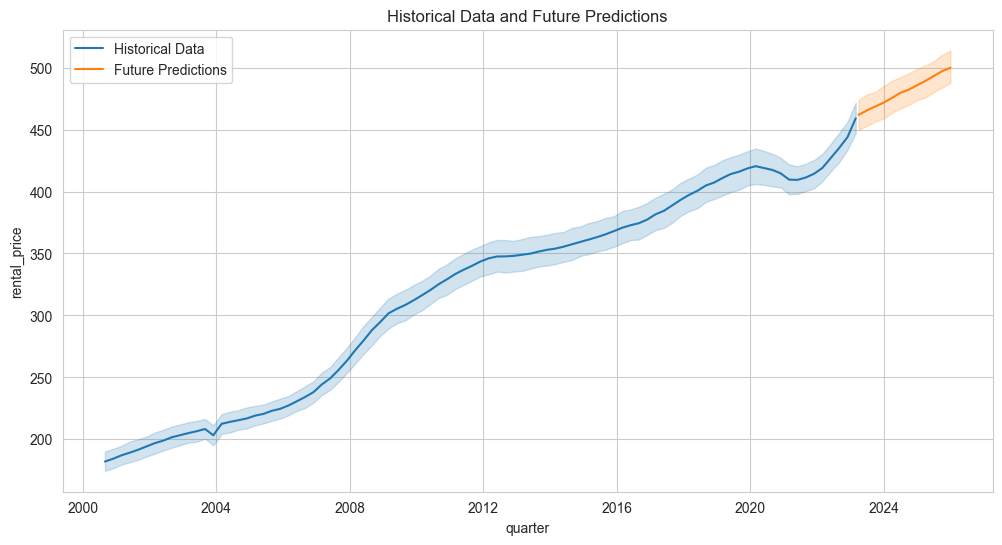

In [121]:
# Plot the future predictions along with the historical data
plt.figure(figsize=(12, 6))
sns.lineplot(x='quarter', y='rental_price', data=data, label='Historical Data')
sns.lineplot(x='quarter', y='rental_price', data=future_predictions_df, label='Future Predictions')
plt.title('Historical Data and Future Predictions')
plt.show()

In [122]:
current_prices = last_known_data.copy()
current_prices.rename(columns={'rental_price': 'current_rental_price'}, inplace=True)

In [123]:
future_predictions_df

,suburb,property_type,count,quarter,rental_price,rental_price_lag1,rental_price_lag2
1,Altona,All properties,4854.0,2023-03-31,433.527597,430.000000,525.000000
2,Armadale,All properties,751.0,2023-03-31,493.279333,490.000000,420.000000
3,Aspendale-Chelsea-Carrum,All properties,1215.0,2023-03-31,498.362695,495.000000,460.000000
4,Bairnsdale,All properties,334.0,2023-03-31,403.443629,400.000000,480.000000
5,Ballarat,All properties,1492.0,2023-03-31,363.288984,360.000000,400.000000
...,...,...,...,...,...,...,...
141,Whittlesea,All properties,1605.0,2025-12-31,479.865923,476.511565,452.606662
142,Williamstown,All properties,563.0,2025-12-31,589.853323,586.499371,473.162876
143,Wodonga,All properties,1173.0,2025-12-31,453.339161,449.695378,583.151206
144,Yarra Ranges,All properties,728.0,2025-12-31,517.488912,514.163691,446.057263


In [124]:
final_predictions = future_predictions_df.groupby(['suburb'])[['rental_price']].last().reset_index()
final_predictions = final_predictions.merge(current_prices, on=['suburb'])

final_predictions['price_change'] = (final_predictions['rental_price'] - final_predictions['current_rental_price']) / \
                                    final_predictions['current_rental_price']
final_predictions

,suburb,rental_price,property_type,count,quarter,current_rental_price,rental_price_lag1,rental_price_lag2,price_change
0,Altona,433.527597,All properties,4854.0,2023-03-01,430.0,420.0,415.0,0.008204
1,Armadale,496.578690,All properties,751.0,2023-03-01,490.0,460.0,450.0,0.013426
2,Aspendale-Chelsea-Carrum,505.219059,All properties,1215.0,2023-03-01,495.0,480.0,480.0,0.020645
3,Bairnsdale,413.883869,All properties,334.0,2023-03-01,400.0,400.0,380.0,0.034710
4,Ballarat,376.475978,All properties,1492.0,2023-03-01,360.0,360.0,360.0,0.045767
...,...,...,...,...,...,...,...,...,...
140,Whittlesea,479.865923,All properties,1605.0,2023-03-01,440.0,430.0,420.0,0.090604
141,Williamstown,589.853323,All properties,563.0,2023-03-01,550.0,540.0,520.0,0.072461
142,Wodonga,453.339161,All properties,1173.0,2023-03-01,410.0,410.0,400.0,0.105705
143,Yarra Ranges,517.488912,All properties,728.0,2023-03-01,478.0,460.0,460.0,0.082613


In [125]:
# Find the percentage change in rental prices from the current prices to end of estimation period
future_prices = future_predictions_df.groupby(['suburb'])[['rental_price']].last().reset_index()
future_prices = future_prices.merge(current_prices, on=['suburb'])
future_prices['price_change'] = (future_prices['rental_price'] - future_prices['current_rental_price']) / future_prices[
    'current_rental_price']